In [128]:
%pylab inline
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times New Roman"]
mpl.rcParams["font.size"] = 12

data = np.genfromtxt('Pos_raw_andLlya.txt')

#taking data from the simulation
Pos_Mpc = data[:,0:3]
L_lya = data[:,3] #case B simple Lya (10**42 SFR)
SFR = data[:,4]
Mass_stel = data[:,5]
Mass_dm = data[:,6]


Populating the interactive namespace from numpy and matplotlib


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select', 'zeros', 'uniform', 'exponential', 'f', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Assuming case B recombination I have assumed an intrinsic Ly$\alpha$ luminosity given by:
$$L_{\rm Ly\alpha} \ [\rm erg \ s^{-1}]= 10^{42} \cdot {\rm SFR \ [M_\odot \ yr^{-1}]}$$

The UV luminosity was estimated starting from the SFR using the Kennicut relation found in the Madau Dickinson review for a Chabrier IMF, which is the IMF used in EAGLE.

$${\rm SFR [M_\odot \ yr^{-1}]} = 0.63 \cdot 1.4 \cdot 10^{-28} L_{\nu} [\rm erg \ s^{-1} \ Hz^{-1}]$$

$$L_{\nu} d\nu = L_{\lambda} d\lambda$$

$$L_{\lambda} = L_{\nu} \frac{d\nu}{d\lambda} = L_{\nu} \frac{c}{\lambda^2} = \frac{\rm SFR}{1.4 \cdot 10^{-28}} \frac{c}{\lambda^2}$$

In our case:

$$L_{1500} = 1.5 \cdot 10^{40} \ \rm SFR$$

Also in Garel et al 2015 they used 1.4 $\cdot 10^{40}$

To copare with Garel 2015
0.07999788224697113 -15.799247376589747
0.7999169230461121 -18.299163363058895
7.92720365524292 -20.789351190146423


Text(0, 0.5, 'M$_1500$')

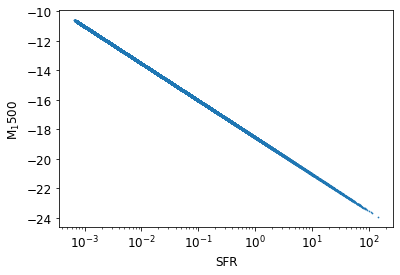

In [129]:
#eliminating halos without SF
ind_nice = np.where(np.logical_or(Mass_stel==0, SFR==0), False, True)
ind_sfr = np.where(SFR>0)

L_lya_n = L_lya[ind_nice]
L_lya   = L_lya[ind_sfr]
Pos_Mpc = Pos_Mpc[ind_sfr]
Mass_stel = Mass_stel[ind_sfr]
SFR     = SFR[ind_sfr]

#L_UV starting from Madau Dickinson review
c = const.c.value*10**2 #[cm/s]
pc = const.pc.value*10**2 #[cm]
lambda_ang = 1500 #[A]
lambda_cm = 1500*10**(-8) #[cm]
val_Kenn = 1.4*10**(-28) #for Salpeter IMF
val_Chabr = val_Kenn*0.63 #for Chabrier IMF

#L_nu = SFR/val_Kenn
L_nu = SFR/val_Chabr
L_1500 = L_nu*c/(lambda_ang*lambda_cm)

#L_1500 = SFR*1.4*10**40
#L_nu = L_1500*lambda_ang*lambda_cm/c
#L_nu = np.array(L_nu).astype(np.float)
M_1500 = -2.5*np.log10(L_nu/(4*np.pi*(10*pc)**2))-48.6

print('To copare with Garel 2015')
print(np.max(SFR[SFR<0.08]), np.min(M_1500[SFR<0.08]))
print(np.max(SFR[SFR<0.8]), np.min(M_1500[SFR<0.8]))
print(np.max(SFR[SFR<8]), np.min(M_1500[SFR<8]))

plt.scatter(SFR, M_1500, s=0.5)
plt.xscale('log')
plt.xlabel('SFR')
plt.ylabel(r'M$_1500$')

## select the function

[11.59264853 11.12199587 10.67343564 ...  0.          0.
  0.        ]


Text(0.5, 1.0, 'pdf(f|SFR = 1)')

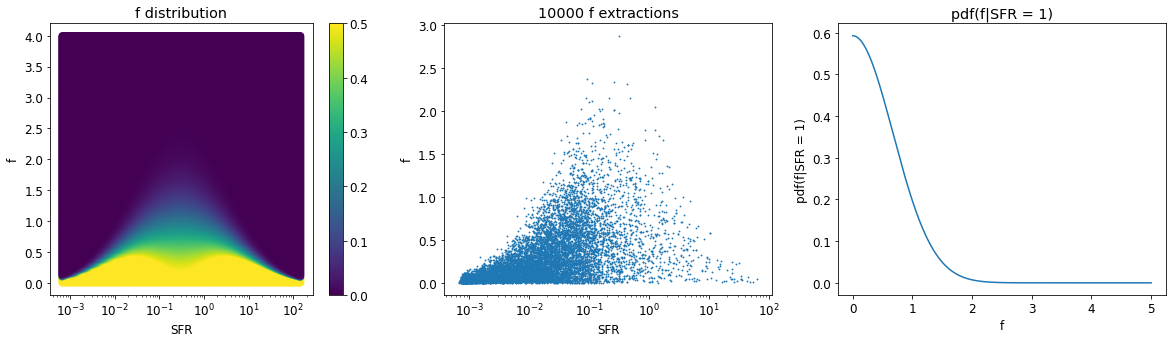

In [130]:
from scipy.stats import norm, uniform
from scipy.integrate import quad
from progress.bar import Bar

#0 = only arctan
#1 = arctan + gaus at 0
#2 = gaus with sigma=rarctan
#3 = 2nd degree pol
#4 = gaus with a 2nd degree poly as a sigma
select = 2


SFR_log = np.log10(SFR)
sfr_min = np.min(SFR_log)#10**(-2)
sfr_max = np.max(SFR_log)
delta=sfr_max-sfr_min
f = np.zeros(len(L_lya))

x_linsp = np.linspace(0,5, 1000)
a=4


def gaus2(x,c, mean_0, sigma_0, mean_1, sigma_1):
    fun = c*norm.pdf(x,mean_0,sigma_0)+norm.pdf(x, mean_1, sigma_1)
    return fun

def zero_to_pi(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)*np.pi/2

def zero_to_one(sfr, sfr_min, sfr_max):
    SFR_log = np.log10(sfr)
    return (SFR_log-sfr_min)/(sfr_max-sfr_min)

def f_dist(sfr,xx, sfr_min,sfr_max, c):
    x_var = zero_to_pi(sfr, sfr_min, sfr_max)  
    
    if select==0:
        mean_1 = np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 1000
        fun = gaus2(xx,0,mean_0,sigma_0, mean_1, sigma_1)
        
    if select==1:
        mean_1 = 1.5*np.arctan(np.pi/2-x_var)
        sigma_1 = 0.2*mean_1+0.03
        mean_0 = 0
        sigma_0 = 0.7*mean_1+0.01
        fun = gaus2(xx,c,mean_0,sigma_0, mean_1, sigma_1)
    
    if select==2:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        sigma_g = 0.38*norm.pdf(x_var, zero_to_one(0.30, sfr_min, sfr_max), 0.20)  #0.36, 0.33, 0.2
        fun = norm.pdf(xx,0, sigma_g)
    
    if select==3:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = -x_var**2+1
        sigma_1 = 0.2*mean_1+0.03
        fun = norm.pdf(xx, mean_1, sigma_1)
        
    if select==4:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = 0.
        sigma_1 =(-x_var**2+1)+0.0001
        fun = norm.pdf(xx, mean_1, sigma_1)
    
    if select==5:
        x_var = zero_to_one(sfr, sfr_min, sfr_max)
        mean_1 = 0.4*norm.pdf(x_var, 0.4, 0.3)
        sigma_1 = 0.2
        fun = norm.pdf(xx, mean_1,sigma_1)
    return fun

max_ext = 2.3
if select==1:
    max_ext=4
if select==2:
    max_ext=4
if select==4:
    max_ext=5.5

fig,ax = plt.subplots(1,3, figsize=(20,5))
aa = np.logspace(sfr_min,sfr_max, 300)
bb = np.linspace(0,max_ext, 300)
AA, BB = np.meshgrid(aa,bb)
AA = AA.reshape(-1)
BB = BB.reshape(-1)
color = f_dist(AA,BB,sfr_min,sfr_max,a)
print(color)
max_color = np.nanmax(f_dist(AA,BB,sfr_min,sfr_max,a))
pl =ax[0].scatter(AA,BB, c=color, vmin=0, vmax=0.5)
plt.colorbar(pl, ax = ax[0])
rand_x = np.random.uniform(0,max_ext,len(SFR_log))
rand_y = np.random.uniform(0, max_color+0.0001, len(SFR_log))
ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max,a))

while len(ind_change[0])!=0:
    #print(len(ind_change[0]))
    rand_x[ind_change[0]] = np.random.uniform(0, max_ext, len(ind_change[0]))
    rand_y[ind_change[0]] = np.random.uniform(0, max_color+0.0001, len(ind_change[0]))
    ind_change = np.where(rand_y>f_dist(SFR, rand_x, sfr_min, sfr_max, a))
    
f = rand_x

#plt.scatter(SFR, f)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[0].set_ylabel('f')
ax[0].set_title('f distribution')

rand_indd = np.random.randint(0,len(L_lya), size=10000)
ax[1].scatter(SFR[rand_indd], f[rand_indd], s=0.7)
ax[1].set_xscale('log')
ax[1].set_xlabel('SFR')
ax[1].set_ylabel('f')
ax[1].set_title('10000 f extractions')


ax[2].plot(x_linsp, f_dist(1, x_linsp, sfr_min, sfr_max, a))
ax[2].set_xlabel('f')
ax[2].set_ylabel('pdf(f|SFR = 1)')
ax[2].set_title('pdf(f|SFR = 1)')


#da SFR -1.5 a -0.5

Text(1, 1.3, '10 M$_\\odot$ yr$^{-1}$')

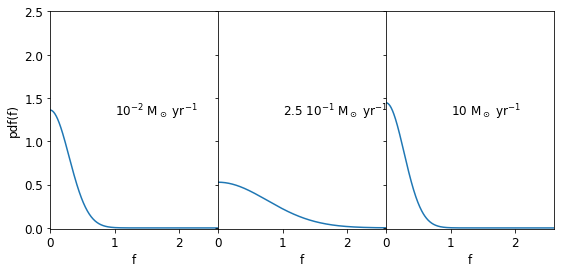

In [131]:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.05, right=0.75,
                      hspace=0., wspace=0.0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax0.plot(x_linsp, f_dist(0.01, x_linsp, sfr_min, sfr_max, a))

ax0.set_xlabel('f')
ax0.set_ylabel('pdf(f)')
ax0.set_xlim(0,2.6)
ax0.text(1, 1.3,'10$^{-2}$ M$_\odot$ yr$^{-1}$')
ax0.set_ylim(-0.01,2.5)

ax1.plot(x_linsp, f_dist(2.5e-1, x_linsp, sfr_min, sfr_max, a))
ax1.set_xlabel('f')
ax1.set_xlim(0,2.6)
ax1.set_ylim(-0.01,2.5)
ax1.text(1, 1.3,'2.5 10$^{-1}$ M$_\odot$ yr$^{-1}$')
ax1.tick_params(labelleft=None)

ax2.plot(x_linsp, f_dist(10, x_linsp, sfr_min, sfr_max, a))
ax2.set_xlabel('f')
ax2.set_xlim(0,2.6)
ax2.set_ylim(-0.01,2.5)
ax2.tick_params(labelleft=None)
ax2.text(1, 1.3,'10 M$_\odot$ yr$^{-1}$')


Text(0.5, 1.0, 'Ly$\\alpha$ luminosity distribution applying f$_{\\rm esc}$')

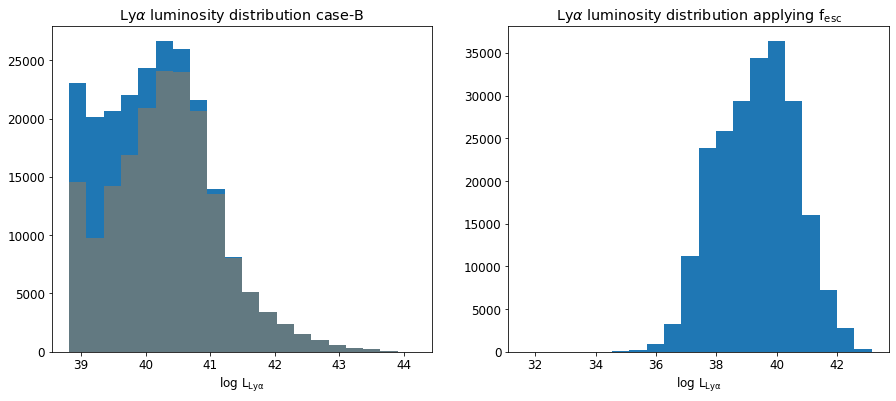

In [132]:
L_lya_obs = L_lya*f

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(np.log10(L_lya), bins=20)
ax[0].hist(np.log10(L_lya_n), bins=20, alpha=0.3)
ax[1].hist(np.log10(L_lya_obs[L_lya_obs!=0]), bins=20)

for i in ax:
    i.set_xlabel(r'log L$_{\rm Ly\alpha}$')
ax[0].set_title(r'Ly$\alpha$ luminosity distribution case-B')
ax[1].set_title(r'Ly$\alpha$ luminosity distribution applying f$_{\rm esc}$')

In [103]:
from lum_func import *
from corr_functions import * 

###LUMINOSITY FUNCTION
av_bin, counts, zeros = Lya_lumfunction(L_lya, 20) #the original case B
av_bin_obs, counts_obs, zeros_obs = Lya_lumfunction(L_lya_obs, 50) #the corrected one

###CORRELATION FUNCTION
N_boot = 25
bins = np.logspace(np.log10(0.1), np.log10(10), 15)
xi = np.zeros((N_boot, len(bins)-1))
xi_obs = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen, xi[i], _ = corr_func(500, bins, Pos_Mpc, 0, 100, False)
    bins_cen_ob, xi_obs[i], _ = corr_func(500, bins, Pos_Mpc[np.logical_and(L_lya_obs>10**41.39, L_lya_obs<10**(42.87))], 0, 100, False)
                                          
                                          #[np.logical_and(L_lya_obs>10**41.39, L_lya_obs<10**(40))], 0, 100, False)
    
med_xi = np.median(xi, axis=0)
sigma_xi = (np.percentile(xi, 75, axis=0) - np.percentile(xi, 25, axis=0))*0.7413

med_xi_obs = np.median(xi_obs, axis=0)
sigma_xi_obs = (np.percentile(xi_obs, 75, axis=0) - np.percentile(xi_obs, 25, axis=0))*0.7413

###EW
EW = L_lya_obs/L_1500*(1500/1216)**(-1.5)

###EW fraction to compare with Kusakabe
Kusakabe_bins = np.array([-21.5, -20, -19, -18, -17])
Kusakabe_bins_cen = (Kusakabe_bins[1:]+Kusakabe_bins[:-1])/2

#dividing galaxies in bins of M_1500
ind_bins = [[] for i in range(len(Kusakabe_bins_cen))]
for i in range(len(Kusakabe_bins)-1):
    ind_bins[i] = np.where(np.logical_and(M_1500>=Kusakabe_bins[i], M_1500<Kusakabe_bins[i+1]))
    
#dividing galaxies in bins of EW
EW_thresh = [25,45,65,85]
EW_fraction = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction[j,i] = len(np.where(EW[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])


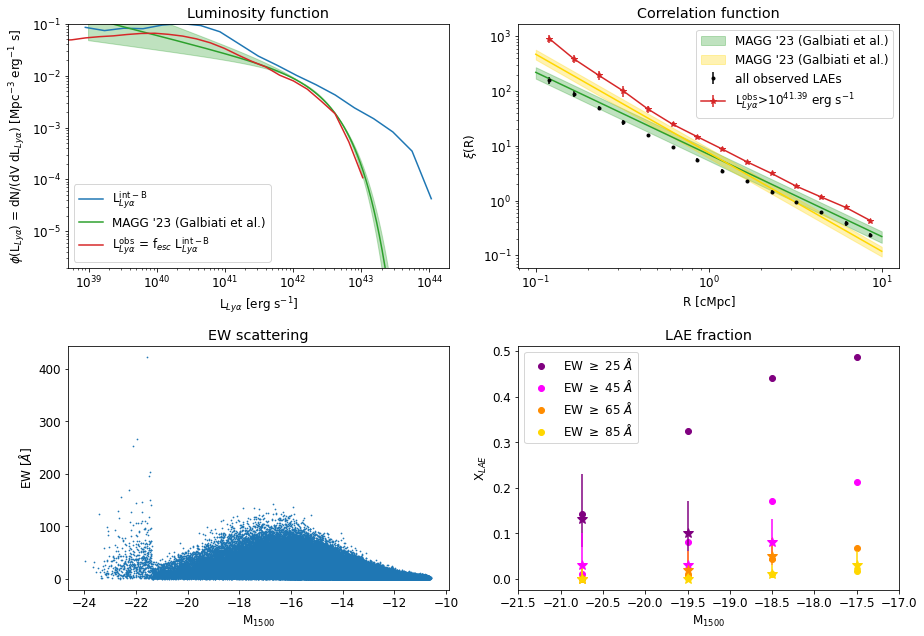

In [126]:
fig, ax = plt.subplots(2,2, figsize=(13,9))
ax=ax.reshape(-1)

##LF
ax[0].plot(av_bin, counts, label=r'L$_{Ly\alpha}^{\mathrm{int-B}}$ ')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Luminosity function')
ax[0].set_ylim(2*10**(-6), 10**(-1))
ax[0].set_xlim()
ax[0].set_xlabel(r'L$_{Ly\alpha}$ [erg s$^{-1}$]')
ax[0].set_ylabel(r'$\phi$(L$_{Ly\alpha}$) = dN/(dV dL$_{Ly\alpha}$) [Mpc$^{-3}$ erg$^{-1}$ s]')

#mackenzie_raw
mack_lf = np.genfromtxt('Mackenzie.txt')
#ax[0].plot(mack_lf[:,0], mack_lf[:,1],label='Mackenzie_raw')

#MAGG LF
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_logsp = np.logspace(39, 44, 500)

magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
ax[0].plot((x_logsp), (magg), label="MAGG '23 (Galbiati et al.)", c='tab:green')
ax[0].fill_between((x_logsp), (magg_1s_min), (magg_1s_max), color='tab:green', alpha=0.3)

#with f_esc
ax[0].plot(av_bin_obs, counts_obs, c='tab:red', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$ = f$_{esc}$ L$_{Ly\alpha}^{\mathrm{int-B}}$') 

ax[0].legend()

##CORRELATION
ax[1].errorbar(bins_cen, med_xi, sigma_xi, fmt='.k', label=r'all observed LAEs')
ax[1].errorbar(bins_cen_ob, med_xi_obs, sigma_xi_obs, color='tab:red', marker='*', label=r'L$_{Ly\alpha}^{\mathrm{obs}}$>10$^{41.39}$ erg s$^{-1}$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('R [cMpc]')
ax[1].set_ylabel(r'$\xi$(R)')
ax[1].set_title('Correlation function')
x_log = np.logspace(-1,1,100)
#ax[1].plot(x_log, (x_log/2.95)**(-1.47), label='from LF calibration')
ax[1].plot(x_log, (x_log*0.6777/2.47)**(-1.5), color='tab:green')
ax[1].fill_between(x_log, (x_log*0.6777/2.07)**(-1.5), (x_log*0.6777/2.85)**(-1.5), color='tab:green', 
                   alpha=0.3, label="MAGG '23 (Galbiati et al.)")
ax[1].plot(x_log, (x_log*0.6777/2.07)**(-1.8), color='gold')
ax[1].fill_between(x_log, (x_log*0.6777/2.30)**(-1.8), (x_log*0.6777/1.83)**(-1.8), color='gold', 
                   alpha=0.3, label="MAGG '23 (Galbiati et al.)")
ax[1].legend()
#add Herrero alonso from magg paper

##EW scatter
ax[2].scatter(M_1500, EW, s=0.5)
ax[2].set_xlabel(r'M$_{1500}$')
ax[2].set_ylabel(r'EW [$\AA$]')
ax[2].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
Kusak_res_25 = [0.13, 0.10]
Kusak_res_25_err = [[0.06,0.04], [0.1, 0.07]]
Kusak_res_45 = [0.03, 0.03, 0.08]
Kusak_res_45_err = [[0.02, 0.02, 0.03],[0.07, 0.03, 0.05]]
Kusak_res_65 = [0.00, 0.02, 0.05]
Kusak_res_65_err = [[0.00, 0.01, 0.02],[0.03,0.04, 0.04]]
Kusak_res_85 = [0.00, 0.00, 0.01, 0.03]
Kusak_res_85_err = [[0.00,0.00,0.00,0.01], [0.03, 0.02, 0.02, 0.03]]

Kusak_res = [Kusak_res_25, Kusak_res_45, Kusak_res_65, Kusak_res_85]
Kusak_err = [Kusak_res_25_err, Kusak_res_45_err, Kusak_res_65_err, Kusak_res_85_err]

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[3].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', markersize=10, ls='', color=color_list[i])
    ax[3].scatter(Kusakabe_bins_cen, EW_fraction[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[3].set_xlim(-21.5, -17)
ax[3].set_xlabel(r'M$_{1500}$')
ax[3].set_ylabel(r'X$_{LAE}$')
ax[3].set_title('LAE fraction')
ax[3].legend()
#ax[3].set_ylim(0,0.3)
fig.tight_layout()


#try to plot xi+1
#plot sfr-mass stel

46.32715914829936


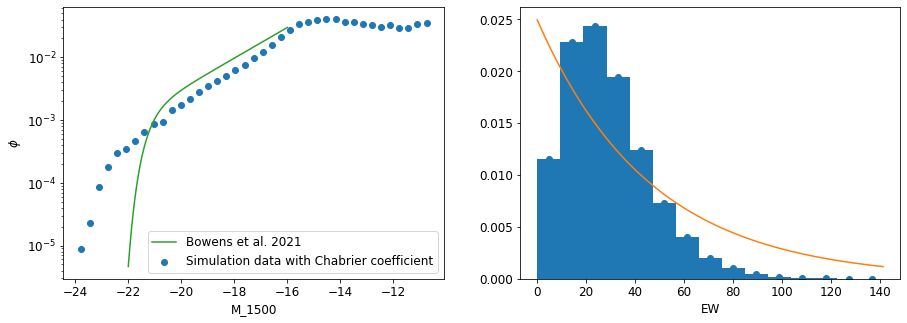

In [105]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
from lum_func import *

av_bin_1500, counts_1500 = lum_func_mag(M_1500, 40)
ax[0].scatter(av_bin_1500, counts_1500, label='Simulation data with Chabrier coefficient')
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('M_1500')
ax[0].set_ylabel(r'$\phi$')

#From Bowens 2021 UV lum function at z about 3
def schechter_fun(M, phi_star, alpha, M_star):
    return phi_star*np.log(10)/2.5*10**((M_star-M)*(alpha +1)/2.5)*np.exp(-10**(M_star-M)/2.5)
Bow_par = [2.1*10**(-3), -1.61, -20.87]
mag_space = np.linspace(-22, -16, 300)
ax[0].plot(mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bowens et al. 2021')
ax[0].legend()
#ax[0].set(xticks= [10**(-23), 10**(-21), 10**(-19), 10**(-17), 10**(-15), 10**(-13), 10**(-11)],
                    # xticklabels= ['-23', '-21', '-19', '-17', '-15', '-13', '-11'])
    
counts_ew, bins_ew = np.histogram(EW[L_lya_obs>10**40], bins=15, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2
ax[1].hist(EW[L_lya_obs>10**40], bins=15, density=True)
ax[1].scatter(bins_cen_ew, counts_ew)
def exponential(x, w0, N):
    return N*np.exp(-x/w0)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew[:], counts_ew[:], p0=[95, 40000]) 
ew_lin = np.linspace(np.min(EW), np.max(EW), 100)
ax[1].plot(ew_lin, exponential(ew_lin, popt[0], popt[1]))
ax[1].set_xlabel('EW')
print(popt[0])

Text(0, 0.5, 'log$_{10}$(Z$_\\star$/Z$_\\odot$)')

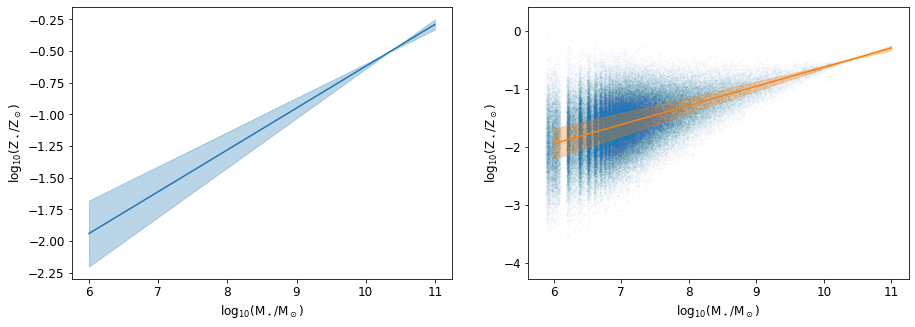

In [106]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
mass_logs = np.linspace(6,11)
ax[0].plot(mass_logs, 0.33*((mass_logs)-10)-0.62)
ax[0].fill_between(mass_logs, 0.27*((mass_logs)-10)-0.60, 0.39*((mass_logs)-10)-0.64, color='tab:blue', alpha=0.3)
ax[0].set_xlabel(r'log$_{10}$(M$_\star$/M$_\odot$)')
ax[0].set_ylabel(r'log$_{10}$(Z$_\star$/Z$_\odot$)')

means_z = 0.33*(np.log10(Mass_stel[Mass_stel>0])-10)-0.62
sigma_z = np.abs((0.27*(np.log10(Mass_stel[Mass_stel>0])-10)-0.60) - (0.39*(np.log10(Mass_stel[Mass_stel>0])-10)-0.64))
random_met = np.random.normal(loc=means_z, scale=sigma_z)

ax[1].scatter(np.log10(Mass_stel[Mass_stel>0]), random_met, alpha=0.02, s=0.7)
ax[1].plot(mass_logs, 0.33*((mass_logs)-10)-0.62,c='tab:orange')
ax[1].fill_between(mass_logs, 0.27*((mass_logs)-10)-0.60, 0.39*((mass_logs)-10)-0.64, color='tab:orange', alpha=0.3)
ax[1].set_xlabel(r'log$_{10}$(M$_\star$/M$_\odot$)')
ax[1].set_ylabel(r'log$_{10}$(Z$_\star$/Z$_\odot$)')

573
0.4401200442826561  +-  0.024116650331795823
-2.9334539060308993  +-  0.24549377039632064
2.1053339026262945 4.4548156395502225 6.938549302032299


Text(0, 0.5, 'A$_{\\rm FUV}$')

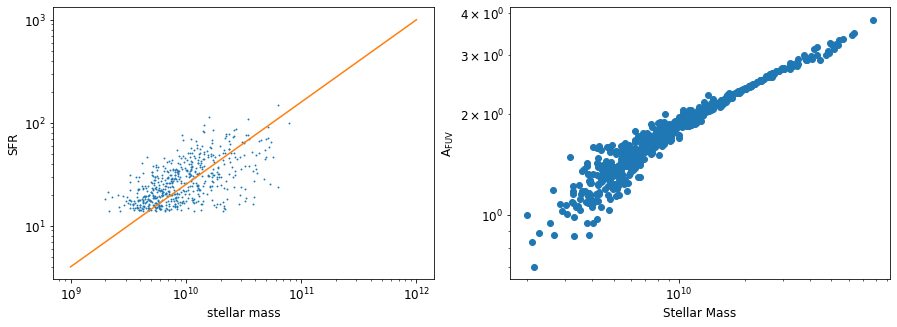

In [107]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ind_uv = np.where((M_1500<-21.4))
#ind_uv = np.where(M_1500<-16)

print(len(ind_uv[0]))
ax[0].scatter(Mass_stel[ind_uv], SFR[ind_uv], s=0.8)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('SFR')
ax[0].set_xlabel('stellar mass')
#ax[0].set_ylim(0.5,6.9)

def powerlaw(x, a, b):
    return 10**b*x**a

from scipy.optimize import curve_fit
popt, pcov = curve_fit(powerlaw, Mass_stel[ind_uv], SFR[ind_uv], p0=[0.8,-6.5])
#popt, pcov = curve_fit(powerlaw, Mass_stel[M_1500<-21], SFR[M_1500<-21], p0=[0.8,-6.5])

mass_lins = np.logspace(9, 12, 50)
ax[0].plot(mass_lins, powerlaw(mass_lins, 0.8, -6.6), color='tab:orange')
#0.8 -6.5
print(popt[0], ' +- ', np.sqrt(pcov[0,0]))
print(popt[1], ' +- ', np.sqrt(pcov[1,1]))

#paper Alvarez-Marquez
def log_IRX(M_star, alpha, IRX_0):
    return alpha*np.log10(M_star/10**(10.35)) + IRX_0

def A_fuv(IRX, BC_dust, BC_fuv):
    return 2.5*np.log10(BC_dust/BC_fuv*IRX + 1)
alpha_m = 0.84
alpha_std = 0.11
irx_0_m = 1.17
irx_0_std = 0.05

#Heinis 2013
#alpha_m = 0.72
#alpha_std= 0.08
#irx_0_m = 1.32
#irx_0_std = 0.04

BC_dust = 1
BC_fuv = 1.68

alpha = np.random.normal(alpha_m, alpha_std, len(Mass_stel[ind_uv]))

IRX = 10**(log_IRX(Mass_stel[ind_uv], alpha, irx_0_m))
Afuv = A_fuv(IRX, BC_dust, BC_fuv)


print(A_fuv(10, BC_dust, BC_fuv), A_fuv(100, BC_dust, BC_fuv), A_fuv(1000, BC_dust, BC_fuv))
ax[1].scatter(Mass_stel[ind_uv], Afuv)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Stellar Mass')
ax[1].set_ylabel(r'A$_{\rm FUV}$')

573



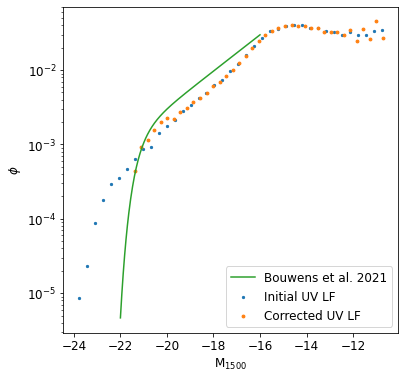

In [108]:
print(len(Afuv))

M_obs = np.copy(M_1500)
M_obs[ind_uv] = M_1500[ind_uv]+Afuv

L_1500_obs = 4*np.pi*((10*pc)**2)*(10**(-(M_obs+48.6)/2.5))*c/(1500*1500*10**(-8))

#print(M_1500[ind_uv], M_obs[ind_uv])

fig, ax = plt.subplots(1,1,figsize=(6,6))

av_bin_obs1500, counts_obs1500 = lum_func_mag(M_obs,40)
ax.scatter(av_bin_1500, counts_1500, label='Initial UV LF', s=5)
ax.scatter(av_bin_obs1500, counts_obs1500, label='Corrected UV LF',s=8)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'M$_{\rm 1500}$')
ax.set_ylabel(r'$\phi$')

#From Bowens 2021 UV lum function at z about 3
def schechter_fun(M, phi_star, alpha, M_star):
    return phi_star*np.log(10)/2.5*10**((M_star-M)*(alpha +1)/2.5)*np.exp(-10**(M_star-M)/2.5)
Bow_par = [2.1*10**(-3), -1.61, -20.87]
Bow_par_err = [0.3*10**(-3), 0.03, 0.09]

mag_space = np.linspace(-22, -16, 300)
#ax.fill_between(mag_space, schechter_fun(mag_space, Bow_par[0]+Bow_par_err[0],  Bow_par[1]+Bow_par_err[1],  Bow_par[2]+Bow_par_err[2]), 
                 #  schechter_fun(mag_space, Bow_par[0]-Bow_par_err[0],  Bow_par[1]-Bow_par_err[1],  Bow_par[2]-Bow_par_err[2]), color='tab:green',
                 # alpha=0.3)
ax.plot(mag_space, schechter_fun(mag_space, Bow_par[0], Bow_par[1], Bow_par[2]), color='tab:green', label='Bouwens et al. 2021')
ax.legend()

print()
plt.savefig('UV luminosity function.pdf')


#applico un fattore e vedo come cambia

2.3657883230937756e+41
2.2360499755472176e+42


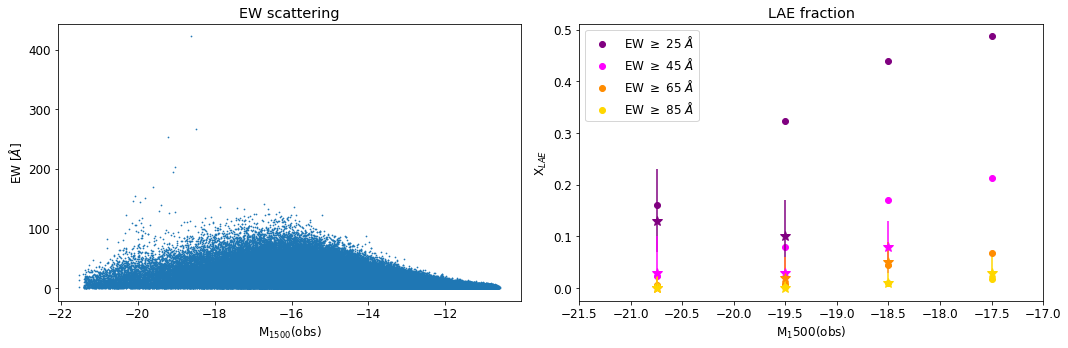

In [109]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
print(np.max(L_1500_obs))
print(np.max(L_1500))

##EW scatter
EW_obs = EW = L_lya_obs/L_1500_obs*(1500/1216)**(-1.5)

ax[0].scatter(M_obs, EW_obs, s=0.5)
ax[0].set_xlabel(r'M$_{1500}$(obs)')
ax[0].set_ylabel(r'EW [$\AA$]')
ax[0].set_title('EW scattering')
#ax[2].set_xscale('log')
#ax[2].set_xlim(-10,-24)
#ax[2].set_ylim(0,90)

##LAE fraction
EW_fraction_obs = np.zeros([len(Kusakabe_bins_cen), len(EW_thresh)])
for j in range(len(Kusakabe_bins_cen)):
    for i in range(len(EW_thresh)):
        EW_fraction_obs[j,i] = len(np.where(EW_obs[ind_bins[j]]>EW_thresh[i])[0])/len(ind_bins[j][0])

color_list = ['purple', 'magenta', 'darkorange', 'gold']
for i in range(4):
    ax[1].errorbar(Kusakabe_bins_cen[:len(Kusak_res[i])], Kusak_res[i], yerr=Kusak_err[i], marker='*', markersize=10, ls='', color=color_list[i])
    ax[1].scatter(Kusakabe_bins_cen, EW_fraction_obs[:,i], label=r'EW $\geq$ %i $\AA$' %EW_thresh[i], color=color_list[i])
ax[1].set_xlim(-21.5, -17)
ax[1].set_xlabel(r'M$_1500$(obs)')
ax[1].set_ylabel(r'X$_{LAE}$')
ax[1].set_title('LAE fraction')
ax[1].legend()
#ax[1].set_ylim(0,0.3)
fig.tight_layout()

## Oyarzun comparison

Text(0.5, 0, 'log Stellar Mass')

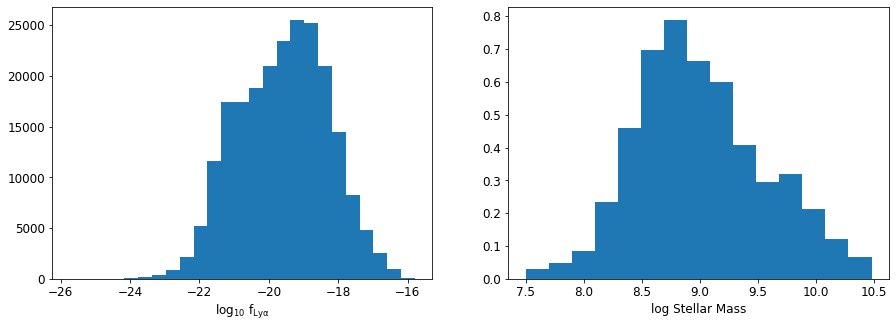

In [110]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307)

z_sim = 3.0165046357126
flux_lya = L_lya_obs/(4*np.pi*(cosmo.luminosity_distance(z_sim).value*10**6*pc)**2)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(np.log10(flux_lya), bins=25)
ax[0].set_xlabel(r'log$_{10}$ f$_{\rm Ly\alpha}$')
ind_flux_lim = np.where(np.logical_and(flux_lya>8*10**(-18), (np.logical_and(Mass_stel>10**7.5, Mass_stel<10**10.5))))
flux_lya_det = flux_lya[ind_flux_lim]
Mass_stel_f = Mass_stel[ind_flux_lim]
SFR_f = SFR[ind_flux_lim]
f_f = f[ind_flux_lim]
EW_f = EW_obs[ind_flux_lim]

ax[1].hist(np.log10(Mass_stel_f), bins=15, density=True)
ax[1].set_xlabel('log Stellar Mass')

4511
103
0.6597296527095476


Text(100, 0.035, 'w0 best : 34.57')

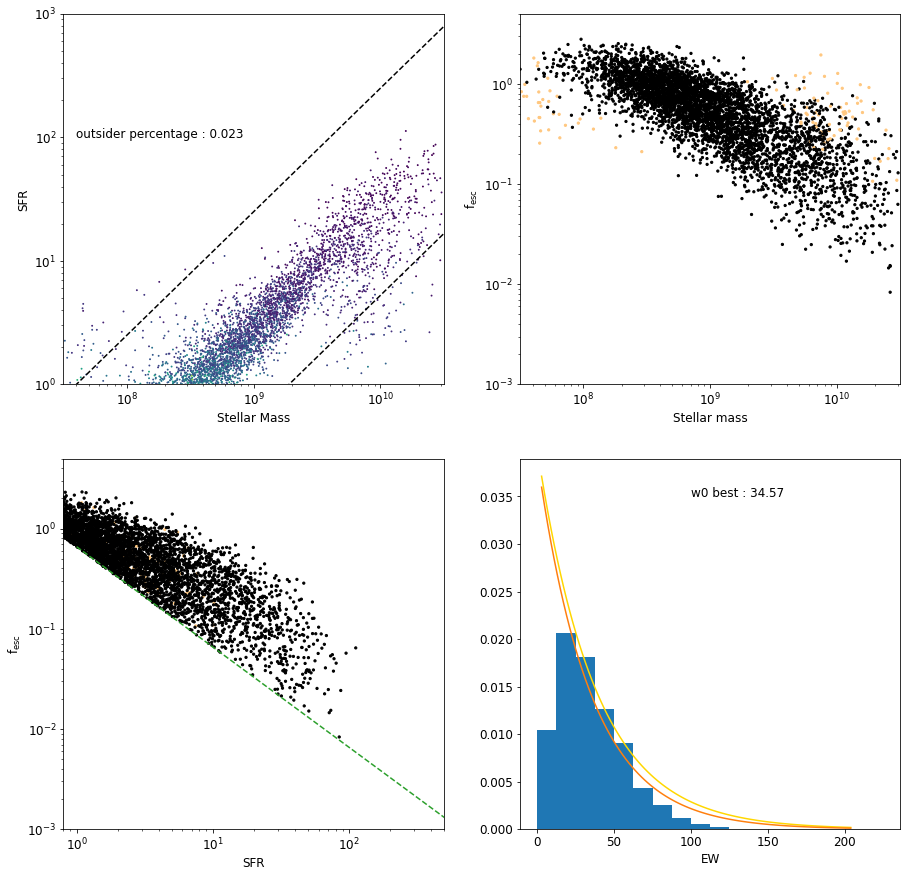

In [111]:
fig, ax = plt.subplots(2,2,figsize=(15,15))
ax = ax.reshape(-1)

ax[0].scatter(Mass_stel_f, SFR_f, c=f_f, s=0.8)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Stellar Mass')
ax[0].set_ylabel('SFR')
ax[0].set_xlim(10**(7.5), 10**(10.5))
ax[0].set_ylim(1, 1000)
m_linspace = np.logspace(7.5,10.5)
ax[0].plot(m_linspace, m_linspace/(40*10**6), ls='--', color='black')
ax[0].plot(m_linspace, m_linspace/(1.9*10**9), ls='--', color='black')

N_tot = len(Mass_stel_f)
print(N_tot)
ind_out = np.where(np.logical_or(SFR_f>Mass_stel_f/(40*10**6), SFR_f<Mass_stel_f/(1.9*10**9)))
N_out =len(ind_out[0])
print(N_out)
perc_out = N_out/N_tot
ax[0].text(10**(7.6), 100, 'outsider percentage : %.3f' %perc_out)

scat_color = np.where(np.logical_or(SFR_f>Mass_stel_f/(40*10**6), SFR_f<Mass_stel_f/(1.9*10**9)), 
                      1, 0)
ax[1].scatter(Mass_stel_f, f_f, s=5, c=scat_color, cmap='copper')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Stellar mass')
ax[1].set_ylabel(r'f$_{\rm esc}$')
ax[1].set_xlim(10**(7.5), 10**(10.5))
ax[1].set_ylim(10**(-3), 5)

ax[2].scatter(SFR_f, f_f, s=5, c=scat_color, cmap='copper')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_xlabel('SFR')
ax[2].set_ylabel(r'f$_{\rm esc}$')
ax[2].set_xlim(0.8, 500)
ax[2].set_ylim(10**(-3), 5)
sfr_linsp = np.logspace(0,3, 100)
f_esc_min = 8*(10**(-18))*(4*np.pi*(cosmo.luminosity_distance(z_sim).value*pc*10**6)**2)/(10**42)
print(f_esc_min)
ax[2].plot(sfr_linsp, f_esc_min/sfr_linsp, c='tab:green', ls = '--')

par_or = [38, 0.04]
ew_bins = np.array([0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 
                    137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225])
ax[3].hist(EW_f, bins=ew_bins, density=True)
counts_ew, bins_ew = np.histogram(EW_f, bins=ew_bins, density=True)
bins_cen_ew = (bins_ew[1:]+bins_ew[:-1])/2

def exponential(x, w0, a):
    return a*np.exp(-x/w0)
def exponential_fixed(x,a):
    return a*np.exp(-x/38)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential, bins_cen_ew[1:], counts_ew[1:], p0=[38, 2]) 
pfix, varfix = curve_fit(exponential_fixed, bins_cen_ew, counts_ew, p0=[0.04])

ew_lin = np.linspace(np.min(EW_f), np.max(EW_f), 100)
ax[3].plot(ew_lin, exponential(ew_lin, par_or[0], par_or[1]), c='gold', label='Oyarzun 2017')
ax[3].plot(ew_lin,exponential(ew_lin, popt[0], popt[1]), c='tab:orange')
ax[3].set_xlabel('EW')
ax[3].text(100, 0.035, 'w0 best : %.2f' %popt[0])

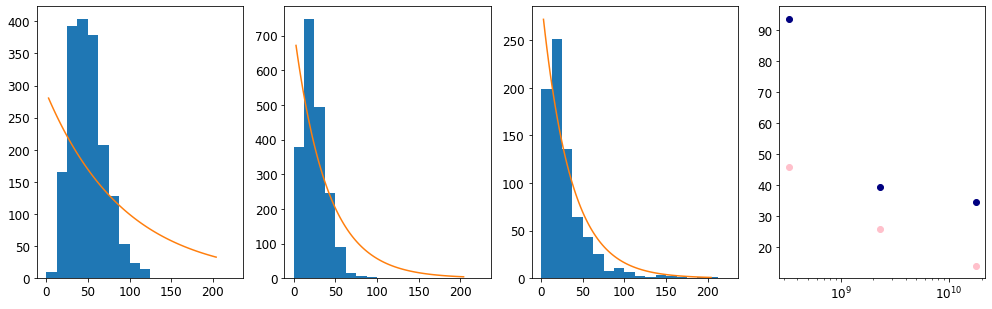

In [112]:
fig, ax = plt.subplots(1,4, figsize=(17,5))

mass_bins = np.array([10**7.5,10**8.8, 10**9.6, 10**10.5])
ew_bins = np.array([0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 
                    137.5, 150, 162.5, 175, 187.5, 200, 212.5, 225])
ew_bins_cen = (ew_bins[1:]+ew_bins[:-1])/2
ew_linsp_f = np.linspace(np.min(EW_f), np.max(EW_f), 100)

counts_lm, bins_lm = np.histogram(EW_f[Mass_stel_f<mass_bins[1]], bins=ew_bins)
ax[0].hist(EW_f[Mass_stel_f<mass_bins[1]], bins=ew_bins)
p_lm, cov_lm = curve_fit(exponential, ew_bins_cen[:], counts_lm[:], p0=[38, 2]) 
ax[0].plot(ew_linsp_f, exponential(ew_linsp_f, p_lm[0], p_lm[1]), c='tab:orange')

counts_mm, bins_mm = np.histogram(EW_f[np.logical_and(Mass_stel_f<mass_bins[2], Mass_stel_f>mass_bins[1])], bins=ew_bins)
ax[1].hist(EW_f[np.logical_and(Mass_stel_f<mass_bins[2], Mass_stel_f>mass_bins[1])], bins=ew_bins)
p_mm, cov_mm = curve_fit(exponential, ew_bins_cen[:], counts_mm[:], p0=[38, 2]) 
ax[1].plot(ew_linsp_f, exponential(ew_linsp_f, p_mm[0], p_mm[1]), c='tab:orange')
           
counts_hm, bins_hm = np.histogram(EW_f[Mass_stel_f>mass_bins[2]], bins=ew_bins)
ax[2].hist(EW_f[Mass_stel_f>mass_bins[2]], bins=ew_bins)
p_hm, cov_hm = curve_fit(exponential, ew_bins_cen[:], counts_hm[:], p0=[38, 2])
ax[2].plot(ew_linsp_f, exponential(ew_linsp_f, p_hm[0], p_hm[1]), c='tab:orange')

ax[3].scatter((mass_bins[1:]+mass_bins[:-1])/2,[p_lm[0], p_mm[0], p_hm[0]], label='this work', c='navy')
ax[3].scatter((mass_bins[1:]+mass_bins[:-1])/2,[46,26,14], label='Oyarzun 2017', c='pink')
ax[3].set_xscale('log')

In [81]:
#Lya emitters losely associated with the absorbers
#HI



In [ ]:
#SFR vs halo mass
#Lya lum vs halo mass

#Rahmati, eop

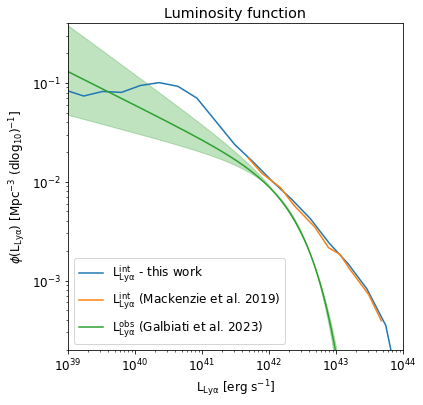

In [125]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
#ax=ax.reshape(-1)

##LF
ax.plot(av_bin, counts, label=r'L$_{\rm Ly\alpha}^{\mathrm{int}}$ - this work')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Luminosity function')
ax.set_ylim(2*10**(-4), 4*10**(-1))
ax.set_xlim(1e39, 1e44)
ax.set_xlabel(r'L$_{\rm Ly\alpha}$ [erg s$^{-1}$]')
ax.set_ylabel(r'$\phi$(L$_{\rm Ly\alpha}$) [Mpc$^{-3}$ (dlog$_{10}$)$^{-1}$]')

#mackenzie_raw
mack_lf = np.genfromtxt('Mackenzie.txt')
ax.plot(mack_lf[:,0], mack_lf[:,1],label=r'L$_{\rm Ly\alpha}^{\mathrm{int}}$ (Mackenzie et al. 2019)')

#MAGG LF
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_logsp = np.logspace(39, 44, 500)

magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])
ax.plot((x_logsp), (magg), label=r"L$_{\rm Ly\alpha}^{\mathrm{obs}}$ (Galbiati et al. 2023)", c='tab:green')
ax.fill_between((x_logsp), (magg_1s_min), (magg_1s_max), color='tab:green', alpha=0.3)


ax.legend()
plt.savefig('Lya_lum_fun_prep.pdf', bbox_inches="tight")